# Final Prediction
- load full census data
- Use Rolling Method
- Feature engineering
- Only output the model and future prediction

In [1]:
pip install us

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime
import calendar
from us import states

import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

## Match to Old Census tract codes

In [31]:
# merge all counties id into one
worksheet1 = pd.read_excel('https://raw.githubusercontent.com/VerneShi/Atlanta_Eviction_Prediction/main/datasets/cobb_county_new_tract.xlsx', dtype=object)
worksheet2 = pd.read_excel('https://raw.githubusercontent.com/VerneShi/Atlanta_Eviction_Prediction/main/datasets/DeKalb_county_new_tract.xlsx', dtype=object)
worksheet3 = pd.read_excel('https://raw.githubusercontent.com/VerneShi/Atlanta_Eviction_Prediction/main/datasets/fulton_county_new_tract.xlsx', dtype=object)
worksheet4 = pd.read_excel('https://raw.githubusercontent.com/VerneShi/Atlanta_Eviction_Prediction/main/datasets/gwinnet_county_new_tract.xlsx', dtype=object)
worksheet5 = pd.read_excel('https://raw.githubusercontent.com/VerneShi/Atlanta_Eviction_Prediction/main/datasets/clayton_county_new_tract.xlsx', dtype=object)

tract_id_difference = pd.concat([worksheet1, worksheet2, worksheet3, worksheet4, worksheet5], ignore_index=True)
tract_id_difference[tract_id_difference.columns] = tract_id_difference[tract_id_difference.columns].astype(str)

## Fecth eviction data

In [32]:
# create a function to fill the missing month in eviction dataset

def fill_missing_months(df, date_column, tract_column):
    # Drop rows with date not in format month/day/year
    df[date_column] = pd.to_datetime(
        df[date_column], format='%m/%d/%Y', errors='coerce')
    df = df.dropna(subset=[date_column])
    df = df[[date_column, tract_column]]

    # Get the unique tracts in the DataFrame
    tracts = df[tract_column].unique()

    filled_dfs = []  # List to store filled DataFrames for each tract

    # Fill missing months for each tract individually
    for tract in tracts:
        # Filter DataFrame for the current tract
        tract_df = df[df[tract_column] == tract]

        # Check if tract_df contains valid rows
        if not tract_df.empty:
            # Get the year from the minimum and maximum dates for the tract
            min_date = tract_df[date_column].dt.date.min()
            max_date = tract_df[date_column].dt.date.max()

            # Create a DataFrame with all months in the year for the tract
            year_range = pd.date_range(start=min_date, end=max_date, freq='MS')
            all_months_df = pd.DataFrame({date_column: year_range})

            # Merge the original tract_df with the all_months_df to fill missing months
            filled_tract_df = pd.merge(
                all_months_df, tract_df, on=date_column, how='left')
            # Insert the tract ID in the filled rows
            filled_tract_df[tract_column] = filled_tract_df[tract_column].fillna(
                tract)

            filled_dfs.append(filled_tract_df)

    # Combine the filled DataFrames for all tracts
    filled_df = pd.concat(filled_dfs)
    filled_df.reset_index(drop=True, inplace=True)

    return filled_df

def get_eviction_data(url: str) -> pd.DataFrame:
  r = requests.get(url)
  json = r.json()

  df = pd.DataFrame(json[0])
  df = df.reset_index()
  df = df.rename(columns={'index': 'date'})

  for i in range(1, len(json)):
    df1 = pd.DataFrame(json[i])
    df1 = df1.reset_index()
    df1 = df1.rename(columns={'index': 'date'})
    df = pd.concat([df, df1], axis=0)

  df.reset_index(drop=True, inplace=True)
  # drop NA values
  df.dropna(axis=0, subset=['TractID'], inplace=True)
  df.drop(df[df['TractID'] == '99999999999'].index, inplace = True)

  # extract last 6 digits from Tract ID for matching Tract ID with census Tract ID
  df['Eviction_Tract'] = df['TractID'].astype(str).str[-6:]
  df['Eviction_Tract'] = df['Eviction_Tract'].str[:-2] + '.' + df['Eviction_Tract'].str[-2:]

  # remove the 0s in front
  df['Eviction_Tract'] = df['Eviction_Tract'].str.lstrip('0')
  # remove the 0s by end of integer tract id
  condition = df['Eviction_Tract'].str.endswith('00')
  df.loc[condition, 'Eviction_Tract'] = df.loc[condition, 'Eviction_Tract'].str[:-3]

  #data clean = drop unnecessary columns
  columns_to_drop = ["TractID", "_id", "updatedOn"]
  df = df.drop(columns = columns_to_drop)
  df.drop_duplicates(subset = ['date', 'Eviction_Tract'], inplace = True)
  df.reset_index(drop=True, inplace=True)

  filled_df = fill_missing_months(df, 'date', 'Eviction_Tract')
  df = filled_df.merge(df, on=['date', 'Eviction_Tract'], how='left')
  df['CountyID'] = df['CountyID'].fillna(method='ffill')

  return df

# create a function to subset the data by year
def subset_by_year(df, year):
  df = df[df['date'].dt.year == year]
  return df

In [12]:
eviction_url = 'https://atl-eviction-tracker.herokuapp.com/rest/tractbymonth'
df_eviction = get_eviction_data(eviction_url)

df_2020 = subset_by_year(df_eviction, 2020)
df_2021 = subset_by_year(df_eviction, 2021)
df_2022 = subset_by_year(df_eviction, 2022)
df_2023 = subset_by_year(df_eviction, 2023)

## Get Yearly Census Data


In [33]:
api_key = "e4f8c3090a4c3bd7eb07351bedbe1a3dc039f53d"  # put census api key here

# Get the state code
state_names = ['GA']  # put the state name here

state_codes_list = []
for i in state_names:
    exec('state_code = states.{}.fips'.format(i))
    state_codes_list.append(state_code)

state_codes_list_str = ','.join(state_codes_list)

# Get the counties
county_list = list(df_eviction.CountyID.unique())
try:
    county_list.remove(None)
except:
    county_list

county_list_str = ','.join(county_list)


In [34]:
def get_census_api_url(variables: list, year: str) -> str:
    ''' get the api url for the variables we want'''
    variables_str = ','.join(variables)
    get_url = 'https://api.census.gov/data/{}/acs/acs5/profile?get=NAME,{}&for=tract:*&in=state:{}&in=county:{}&key={}'.format(
        year, variables_str, state_codes_list_str, county_list_str, api_key)
    return(get_url)


def get_census_api_data(url: str) -> pd.DataFrame:
    '''get the census data from api url'''
    r = requests.get(url)
    json = r.json()
    dff = pd.DataFrame(json)

    # format the data frame
    dff.columns = dff.iloc[0]
    dff = dff[1:]
    dff.reset_index(drop=True, inplace=True)
    return(dff)

def match_census_data(df: pd.DataFrame, tract_match: pd.DataFrame, feature_list: list) -> pd.DataFrame:
  # match the tract code to the old tract code and add-up

  # extract last 5 digits from ACS data and replace old 'tract' column
  df['tract'] = df['tract'].astype(str).str[-6:]
  df['tract'] = df['tract'].str[:-2] + '.' + df['tract'].str[-2:]

  # remove the 0s in front
  df['tract'] = df['tract'].str.lstrip('0')
  # remove the 0s by end of integer tract id
  condition = df['tract'].str.endswith('00')
  df.loc[condition, 'tract'] = df.loc[condition, 'tract'].str[:-3]

  df = df.merge(tract_match, left_on='tract', right_on='Census_Tract')
  df = df.drop(columns = ['Census_Tract'])

  df[feature_list] = df[feature_list].astype(float)
  df = df.groupby(['Eviction_Tract', 'state', 'county'])[feature_list].sum().reset_index()

  return df

def get_yearly_census_data(year: str, df_tract_match: pd.DataFrame) -> pd.DataFrame:
    # Define the lists of variables for each category

    race_list = ['DP05_0037E', 'DP05_0038E', 'DP05_0039E',
                 'DP05_0044E', 'DP05_0052E', 'DP05_0057E']
    edu_list = ['DP02_0060E', 'DP02_0061E', 'DP02_0062E', 'DP02_0063E', 'DP02_0064E',
                'DP02_0065E', 'DP02_0066E']
    income_list = ['DP03_0052E', 'DP03_0053E', 'DP03_0054E', 'DP03_0055E',
                   'DP03_0056E', 'DP03_0057E', 'DP03_0058E', 'DP03_0059E', 'DP03_0060E', 'DP03_0061E']
    occ_list = ['DP03_0027E', 'DP03_0028E',
                'DP03_0029E', 'DP03_0030E', 'DP03_0031E']
    ind_list = ['DP03_0032E', 'DP03_0033E', 'DP03_0034E', 'DP03_0035E', 'DP03_0036E',
                'DP03_0037E', 'DP03_0038E', 'DP03_0039E', 'DP03_0040E', 'DP03_0041E',
                'DP03_0042E', 'DP03_0043E', 'DP03_0044E', 'DP03_0045E']
    worker_list = ['DP03_0047E', 'DP03_0048E', 'DP03_0049E', 'DP03_0050E']
    emp_list = ['DP03_0002E', 'DP03_0003E', 'DP03_0004E', 'DP03_0005E', 'DP03_0006E', 'DP03_0007E']
    house_list = ['DP04_0046E', 'DP04_0047E', 'DP04_0005E', 'DP04_0049E']
    sex_list = ['DP05_0002E', 'DP05_0003E']
    rent_list = ['DP04_0127E',	'DP04_0128E',	'DP04_0129E',	'DP04_0130E',	'DP04_0131E',	'DP04_0132E',	'DP04_0133E',	'DP04_0135E']
    rent_over_income_list = ['DP04_0137E',	'DP04_0138E',	'DP04_0139E',	'DP04_0140E',	'DP04_0141E',	'DP04_0142E',	'DP04_0143E']


    # Generate the URLs for each category
    url_race = get_census_api_url(race_list, year)
    url_edu = get_census_api_url(edu_list, year)
    url_income = get_census_api_url(income_list, year)
    url_occ = get_census_api_url(occ_list, year)
    url_ind = get_census_api_url(ind_list, year)
    url_worker = get_census_api_url(worker_list, year)
    url_emp = get_census_api_url(emp_list, year)
    url_house = get_census_api_url(house_list, year)
    url_sex = get_census_api_url(sex_list, year)
    url_rent = get_census_api_url(rent_list, year)
    url_rent_over_income = get_census_api_url(rent_over_income_list, year)

    # Fetch the data for each category
    df_race = get_census_api_data(url_race)
    df_edu = get_census_api_data(url_edu)
    df_income = get_census_api_data(url_income)
    df_occ = get_census_api_data(url_occ)
    df_ind = get_census_api_data(url_ind)
    df_worker = get_census_api_data(url_worker)
    df_emp = get_census_api_data(url_emp)
    df_house = get_census_api_data(url_house)
    df_sex = get_census_api_data(url_sex)
    df_rent = get_census_api_data(url_rent)
    df_rent_over_income = get_census_api_data(url_rent_over_income)

    # match the tract code to the old tract code and add-up
    df_race = match_census_data(df_race, df_tract_match, race_list)
    df_edu = match_census_data(df_edu, df_tract_match, edu_list)
    df_income = match_census_data(df_income, df_tract_match, income_list)
    df_occ = match_census_data(df_occ, df_tract_match, occ_list)
    df_ind = match_census_data(df_ind, df_tract_match, ind_list)
    df_worker = match_census_data(df_worker, df_tract_match, worker_list)
    df_emp = match_census_data(df_emp, df_tract_match, emp_list)
    df_house = match_census_data(df_house, df_tract_match, house_list)
    df_sex = match_census_data(df_sex, df_tract_match, sex_list)
    df_rent = match_census_data(df_rent, df_tract_match, rent_list)
    df_rent_over_income = match_census_data(df_rent_over_income, df_tract_match, rent_over_income_list)

    # Merge the data frames
    df_census = df_race.merge(
        df_edu, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_income, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_occ, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_ind, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_worker, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_emp, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_house, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_sex, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_rent, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_rent_over_income, on=['Eviction_Tract', 'state', 'county'], how='left')

    return df_census

In [35]:
ACS_2020 = get_yearly_census_data('2020', tract_id_difference)
ACS_2021 = get_yearly_census_data('2021', tract_id_difference)

## Merge Eviction and Census data


In [38]:
# No ACS data for 2022 and after
def merge_census_and_eviction(census_df, eviction_df):
    eviction_df_copy = eviction_df.copy()

    # Rename the CountyID column as county
    eviction_df_copy = eviction_df_copy.drop(columns = ['CountyID'], axis = 1)

    # drop tracts that are in several counties
    tmp = census_df.groupby(['Eviction_Tract'])['county'].count().reset_index()
    l = tmp.loc[tmp.county > 1, 'Eviction_Tract'].tolist()
    census_df_copy = census_df.loc[census_df['Eviction_Tract'].isin(l) == 0]

    # Merge the evicted data and census data
    merged_df = eviction_df_copy.merge(
        census_df_copy, on=['Eviction_Tract'], how='left')

    return merged_df

# Create Year, Month and Day column
def date_preprocess(all_data):
    all_data['date'] = pd.to_datetime(all_data['date'])
    all_data['year'] = all_data['date'].dt.year
    all_data['month'] = all_data['date'].dt.month
    all_data['day'] = all_data['date'].dt.day
    return all_data

In [39]:
# Concat the merged data frames
merged_2020 = merge_census_and_eviction(ACS_2020, df_2020)
merged_2021 = merge_census_and_eviction(ACS_2021, df_2021)
merged_2022 = merge_census_and_eviction(ACS_2021, df_2022)
merged_2023 = merge_census_and_eviction(ACS_2021, df_2023)

data = pd.concat([merged_2020, merged_2021, merged_2022, merged_2023], ignore_index=True)
data = date_preprocess(data)

## Model


In [41]:
def get_new_features(data: pd.DataFrame, lag: int, cutoff: str) -> pd.DataFrame:

    df = data.copy()
    df = df.rename(columns = {'Eviction_Tract': 'tract'})

    # drop all rows with missing values except FilingsByMonth
    sub = df.columns.to_list()
    sub.remove('FilingsByMonth')
    df = df.dropna(subset=sub, how='any')
    df.reset_index(drop=True, inplace=True)

    # sort the dataframe by tract and date
    df = df.sort_values(['state', 'county', 'tract', 'date'], ascending=True)
    df.reset_index(drop=True, inplace=True)

    # add lag terms into the dataframe
    for i in range(1, lag + 1):
      df[f'FilingsByMonth_lag{i}'] = df.groupby(['state', 'county', 'tract'])['FilingsByMonth'].shift(i)

    # drop all rows with FilingsByMonth missing
    df = df.dropna(subset=['FilingsByMonth'], how='any')
    df.reset_index(drop=True, inplace=True)

    # Binning based on FilingsByMonth
    # Only use the average data before cutoff in case of data leekage
    tmp = df.query('date < @cutoff').groupby('tract').agg(FilingsByMonth_mean = ('FilingsByMonth', 'mean')).reset_index()

    # eviction: super low low mid high (use eviction before cutoff)
    tmp['super_low_eviction'] = 0
    tmp.loc[tmp.query('FilingsByMonth_mean <= 5').index, 'super_low_eviction'] = 1

    tmp['low_eviction'] = 0
    tmp.loc[tmp.query('FilingsByMonth_mean > 5 and FilingsByMonth_mean <= 20').index, 'low_eviction'] = 1

    tmp['mid_eviction'] = 0
    tmp.loc[tmp.query('FilingsByMonth_mean > 20 and FilingsByMonth_mean <= 60').index, 'mid_eviction'] = 1

    tmp['high_eviction'] = 0
    tmp.loc[tmp.query('FilingsByMonth_mean > 60').index, 'high_eviction'] = 1

    tmp = tmp.drop(columns = ['FilingsByMonth_mean'], axis = 1)

    df = df.merge(tmp, on = ['tract'], how = 'left')

    # CARES Act Moratorium: April 2020- July 2020
    df['CARES'] = 0
    df.loc[df.query('date >= "2020-04-01" and date <= "2020-07-01"').index, 'CARES'] = 1

    # CDC Moratorium: September 2021 - September 2022
    df['CDC'] = 0
    df.loc[df.query('date >= "2021-09-01" and date <= "2022-09-01"').index, 'CDC'] = 1

    # processing categorical variables

    # for features with a few categories, use onehot encoding
    le = LabelEncoder()
    df['tract_encoded'] = le.fit_transform(df['tract'])

    # for features with a lot of categories, use label encoding
    df = pd.get_dummies(df, columns=['state', 'county'])

    return df


### Rolling Model

In [42]:
def prepare_data(target_column: str, feature_list: list, df: pd.DataFrame):
  X = df[feature_list]
  y = df[target_column]
  return X, y

def rolling_prediction(cutoff: str, lag: int, rolling_number: int, df: pd.DataFrame, model = False):

  # use the cutoff to separate the training set and the testing set
  cutoff_date = pd.to_datetime(cutoff)

  # set the target column
  target = 'FilingsByMonth'

  # get the feature names
  features = df.columns.to_list()
  features.remove(target)
  features.remove('date')

  cat_list = df.select_dtypes(include=['object']).columns
  for i in cat_list:
    features.remove(i)

  if model == False:
    # get training set
    df_training = df.query('date < @cutoff_date').reset_index(drop=True)

    X_train, y_train = prepare_data(target, features, df_training)

    # Build model
    model = xgb.XGBRegressor(
      booster='gbtree', objective='reg:squarederror', n_estimators=100, learning_rate = 0.05, max_depth = 5, colsample_bytree = 0.7)
    # Train model
    model.fit(X_train, y_train, verbose=False)  # Change verbose to True if you want to see it train

  cutoff_new = df.query('date < @predict_month').date.max()
  df_testing = df.query('date == @cutoff_new').reset_index(drop=True)
  df_testing['date'] = cutoff_date
  df_testing = date_preprocess(df_testing)
  df_testing['FilingsByMonth_lag1'] = df_testing['FilingsByMonth']
  df_testing = df_testing.drop(columns = ['FilingsByMonth'], axis = 1)
  X_test = df_testing[features]

  df_testing['FilingsByMonth_prediction'] = model.predict(X_test)
  df_testing['FilingsByMonth_prediction'] = df_testing['FilingsByMonth_prediction'].round().astype(int)
  df_result = df_testing[['date', 'tract', 'FilingsByMonth_prediction']]

  if rolling_number == 1:
    return df_result, model

  else:
    for i in range(1, rolling_number):
      cutoff_new = cutoff_date + pd.DateOffset(months=i)
      # use the prediction to replace the lag term
      for j in range(lag, 1, -1):
        df_testing[f'FilingsByMonth_lag{j}'] = df_testing[f'FilingsByMonth_lag{j-1}']

      df_testing = df_testing.drop(columns = ['FilingsByMonth_lag1', 'FilingsByMonth_prediction'], axis = 1)
      df_testing = df_testing.merge(df_result[['tract', 'FilingsByMonth_prediction']], on = ['tract'], how = 'left')
      df_testing = df_testing.rename(columns = {'FilingsByMonth_prediction': 'FilingsByMonth_lag1'})
      df_testing['date'] = cutoff_new
      df_testing = date_preprocess(df_testing)
      X_test = df_testing[features]

      df_testing['FilingsByMonth_prediction'] = model.predict(X_test)
      df_testing['FilingsByMonth_prediction'] = df_testing['FilingsByMonth_prediction'].round().astype(int)
      df_result = df_testing[['date', 'tract', 'FilingsByMonth_prediction']]

    return df_result


In [43]:
# Set which month is the first month of the prediction
predict_month = '2023-07-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)
df_result_6m = rolling_prediction(predict_month, 13, 6, df, model = model_1m)

### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

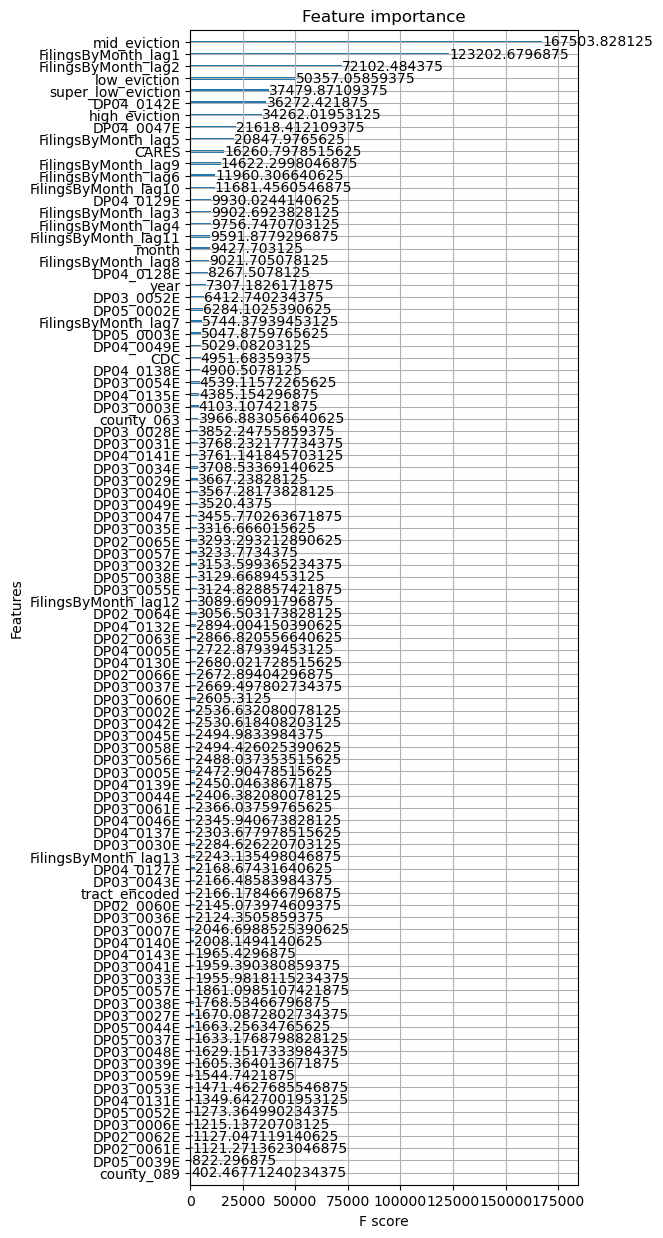

In [44]:
plt.rcParams['figure.figsize'] = (5, 15)
xgb.plot_importance(model_1m, importance_type='gain')

In [45]:
feature_importance = model_1m.get_booster().get_score(importance_type='gain')
feature_importance = pd.DataFrame({'feature': feature_importance.keys(
), 'importance': feature_importance.values()}).sort_values('importance', ascending=False)

feature_importance.reset_index(drop = True, inplace = True)
feature_importance

,feature,importance
0,mid_eviction,167503.828125
1,FilingsByMonth_lag1,123202.679688
2,FilingsByMonth_lag2,72102.484375
3,low_eviction,50357.058594
4,super_low_eviction,37479.871094
...,...,...
89,DP03_0006E,1215.137207
90,DP02_0062E,1127.047119
91,DP02_0061E,1121.271362
92,DP05_0039E,822.296875
